## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import csv
import numpy as np
import os
import csv
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf

from nltk.corpus import stopwords

from string import punctuation

from keras import backend as K
from keras import initializers, regularizers, constraints

seed = 1
np.random.seed(seed)
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Data Tuning

Training Datasets - FNC

In [2]:
!wget -O Data/train_bodies.csv https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/train_bodies.csv
!wget -O Data/train_stances.csv https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/train_stances.csv
df_train_bodies = pd.read_csv('Data/train_bodies.csv')
df_train = pd.read_csv('Data/train_stances.csv')
df_train.replace('agree',0,True)
df_train.replace('disagree',1,True)
df_train.replace('discuss',2,True)
df_train.replace('unrelated',3,True)
train = df_train.join(df_train_bodies.set_index('Body ID'), on='Body ID')
train.to_csv('Data/combined_df_train.csv')

--2022-04-08 22:08:23--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/train_bodies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3752301 (3.6M) [text/plain]
Saving to: ‘Data/train_bodies.csv’

Data/train_bodies.c 100%[===================>]   3.58M  --.-KB/s    in 0.06s   

2022-04-08 22:08:24 (63.1 MB/s) - ‘Data/train_bodies.csv’ saved [3752301/3752301]

--2022-04-08 22:08:24--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/train_stances.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

Testing Dataset - FNC

In [3]:
!wget -O Data/test_bodies.csv https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/competition_test_bodies.csv
!wget -O Data/test_stances.csv https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/competition_test_stances.csv
df_test_bodies = pd.read_csv('Data/test_bodies.csv')
df_test = pd.read_csv('Data/test_stances.csv')
df_test.replace('agree',0,True)
df_test.replace('disagree',1,True)
df_test.replace('discuss',2,True)
df_test.replace('unrelated',3,True)
test = df_test.join(df_test_bodies.set_index('Body ID'), on='Body ID')
test.to_csv('Data/combined_df_test.csv')

--2022-04-08 22:08:35--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/competition_test_bodies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2045680 (2.0M) [text/plain]
Saving to: ‘Data/test_bodies.csv’

Data/test_bodies.cs 100%[===================>]   1.95M  --.-KB/s    in 0.05s   

2022-04-08 22:08:35 (38.9 MB/s) - ‘Data/test_bodies.csv’ saved [2045680/2045680]

--2022-04-08 22:08:35--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/competition_test_stances.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)

To tackle data biases, performing undersampling of the majority data ie stance == 3

In [4]:
to_remove = np.random.choice(train[train['Stance']==3].index,size=17990,replace=False)
train = train.drop(to_remove)
train['Stance'].value_counts(normalize=True) * 100

3    58.017010
2    27.856294
0    11.500219
1     2.626477
Name: Stance, dtype: float64

## Setting up

Extracting words from the dataset given - headline and article body each. 

In [5]:
train_head_s = [text_to_word_sequence(head) for head in train['Headline']]
train_body_s = [text_to_word_sequence(body) for body in train['articleBody']]
test_head_s = [text_to_word_sequence(head) for head in test['Headline']]
test_body_s = [text_to_word_sequence(body) for body in test['articleBody']]

Appending all words from headings of training dataset

In [6]:
list_words = []

for i in range(len(train_head_s)):
    list_words.append(train_head_s[i])

print(len(list_words))

31982


Appending all words from each article body of training dataset

In [7]:
for i in range(len(train_body_s)):
    list_words.append(train_body_s[i])
    
print(len(list_words))

63964


Tokenzining the data and extracting the size of vocabulary to be used.

In [8]:
symbols = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer = Tokenizer(num_words= 30000, filters = symbols)
tokenizer.fit_on_texts([word for word in list_words])
print("Size of Vocabulary:", len(tokenizer.word_index))

Size of Vocabulary: 27873


Maintaining the length of the list and combining words from both headings and article body

In [9]:
train_seq = [list(i) for i in train_head_s]
for i in range(len(train_head_s)):
    train_seq[i].extend(train_body_s[i]) 
    
test_seq = [list(i) for i in test_head_s]
for i in range(len(test_head_s)):
    test_seq[i].extend(test_body_s[i])

In [10]:
print(len(train_seq))
print(len(test_seq))

31982
25413


Truncating words more than 128 for test and train lists

In [11]:
X_train = tokenizer.texts_to_sequences([' '.join(seq[:128]) for seq in train_seq])
X_train = pad_sequences(X_train, maxlen = 128, padding = 'post', truncating = 'post')
y_train = train['Stance']

In [12]:
X_test = tokenizer.texts_to_sequences([' '.join(seq[:128]) for seq in test_seq])
X_test = pad_sequences(X_test, maxlen = 128, padding = 'post', truncating = 'post')
y_test = test['Stance']

Encoding the labels for training data

In [13]:
train_encoding = LabelEncoder()
train_encoding.fit(y_train)
train_encoding_done = train_encoding.transform(y_train)
y_train = np_utils.to_categorical(train_encoding_done)

Test-Train split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.2)

Encoding the labels for testing data

In [15]:
test_encoding = LabelEncoder()
test_encoding.fit(y_test)
test_encoding_done = test_encoding.transform(y_test)
y_test = np_utils.to_categorical(test_encoding_done)

Verifying the structure of the splits

In [16]:
print("Shape of X_train:",X_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)

Shape of X_train: (25585, 128)
Shape of X_test: (25413, 128)
Shape of y_train: (25585, 4)
Shape of y_test: (25413, 4)


In [17]:
import gensim

Creating word embeddings from Glove 60d pretrained model 

In [18]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
!ls
!pwd

--2022-04-08 22:09:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-08 22:09:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-08 22:09:22--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Extracting word embeddings from glove

In [19]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [20]:
!pip install --upgrade gensim

In [21]:
inp = 'glove.6B.50d.txt'
out = 'glove.6B.50d.txt.word2vec'

glove2word2vec(inp, out)
word_embed = gensim.models.KeyedVectors.load_word2vec_format(out, binary = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  after removing the cwd from sys.path.


Adding the weight matrix

In [22]:
weight_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, 50)) 

for word, i in tokenizer.word_index.items(): 
    try:
        word_embed_vector = word_embed[word]
    except KeyError:
        word_embed_vector = None
    if word_embed_vector is not None:
        weight_matrix[i] = word_embed_vector
                
del word_embed

## CNN Training

Defining the model layers

In [23]:
import keras
from keras.layers import Input, Dense, Embedding, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

keras.backend.clear_session()

model = Sequential()

model.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 50, weights = [weight_matrix], trainable = True, input_length = 128))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = 0.3))
model.add(Dense(4,activation ='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.save('models/CNN_final.h5')

Tracking the training time for the model

In [24]:
import time

start = time.time()
history = model.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))
print("Total time: ", time.time() - start, "seconds")

Epoch 1/20
200/200 [==============================] - 51s 245ms/step - loss: 0.9254 - accuracy: 0.6148 - val_loss: 0.7456 - val_accuracy: 0.6908
Epoch 2/20
200/200 [==============================] - 28s 141ms/step - loss: 0.6272 - accuracy: 0.7462 - val_loss: 0.5681 - val_accuracy: 0.7752
Epoch 3/20
200/200 [==============================] - 28s 141ms/step - loss: 0.4339 - accuracy: 0.8313 - val_loss: 0.4723 - val_accuracy: 0.8155
Epoch 4/20
200/200 [==============================] - 30s 149ms/step - loss: 0.3135 - accuracy: 0.8811 - val_loss: 0.4470 - val_accuracy: 0.8310
Epoch 5/20
200/200 [==============================] - 28s 141ms/step - loss: 0.2266 - accuracy: 0.9148 - val_loss: 0.4317 - val_accuracy: 0.8420
Epoch 6/20
200/200 [==============================] - 30s 151ms/step - loss: 0.1764 - accuracy: 0.9339 - val_loss: 0.4091 - val_accuracy: 0.8610
Epoch 7/20
200/200 [==============================] - 28s 141ms/step - loss: 0.1380 - accuracy: 0.9501 - val_loss: 0.4619 - val_ac

## Results

In [25]:
import pickle

with open('CNN.pickle', 'wb') as f:
    pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://26ac2c38-2a44-4a80-a875-3b27019d6609/assets


In [26]:
with open('CNN.pickle', 'rb') as f:
    history = pickle.load(f)

Plotting the accuracy results

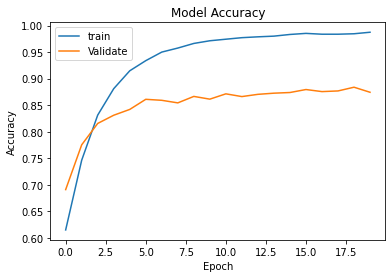

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'Validate'])
plt.show()

Plotting the loss evaluations

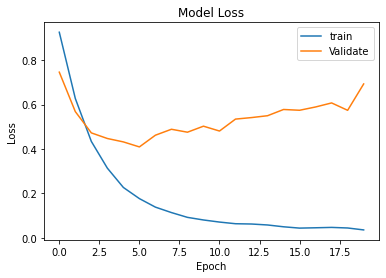

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validate'])
plt.show()

Defining the stance predictions

In [29]:
pred = model.predict(X_test)
predicted_stances = [np.argmax(p, axis = -1) for p in pred]
given_stances = [np.argmax(p, axis = -1) for p in y_test]

Converting stances to texts again

In [30]:
for i in range(len(predicted_stances)):
    if predicted_stances[i] == 0: predicted_stances[i] = "agree"
    if predicted_stances[i] == 1: predicted_stances[i] = "disagree"
    if predicted_stances[i] == 2: predicted_stances[i] = "discuss"
    if predicted_stances[i] == 3: predicted_stances[i] = "unrelated"

for i in range(len(given_stances)):
    if given_stances[i] == 0: given_stances[i] = "agree"
    if given_stances[i] == 1: given_stances[i] = "disagree"
    if given_stances[i] == 2: given_stances[i] = "discuss"
    if given_stances[i] == 3: given_stances[i] = "unrelated"

Extracting the unlabelled testing dataset from FNC

In [31]:
!wget -O Data/test_stances_unlabelled.csv https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_stances_unlabeled.csv
test_df = pd.read_csv('Data/test_stances_unlabelled.csv')

--2022-04-08 22:24:32--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_stances_unlabeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1940688 (1.9M) [text/plain]
Saving to: ‘Data/test_stances_unlabelled.csv’

Data/test_stances_u 100%[===================>]   1.85M  --.-KB/s    in 0.03s   

2022-04-08 22:24:32 (54.2 MB/s) - ‘Data/test_stances_unlabelled.csv’ saved [1940688/1940688]



Checking the shape of this dataset

In [32]:
test_df.shape

(25413, 2)

Adding the predicted stances to unlabeled testing data from FNC

In [33]:
bodyid = []
headline = []

for i in range(len(test_df)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])

Storing the results in a csv

In [34]:
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": predicted_stances})

In [35]:
df_submit.to_csv('answer.csv', index = False, encoding = 'utf-8')

Evaluate the total accuracy and loss for the model

In [36]:
score, acc = model.evaluate(X_test, y_test, batch_size = 128)

199/199 [==============================] - 6s 31ms/step - loss: 2.4753 - accuracy: 0.6590


In [37]:
print("Accuracy:", acc)

Accuracy: 0.6589934229850769


In [38]:
print("Loss:", score)

Loss: 2.475309371948242


Verifying the structure of answer.csv for submission requirements

In [39]:
df_submit.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,discuss


In [40]:
df_submit.shape

(25413, 3)